## 농산물 예측 데이터 이해
- 시계열 예측을 하기 전, 어떤 주기적 패턴이 있다고 파악
- 공휴일과 대체공휴일을 이상치로 판단
- 일요일에도 거래량이나, 가격이 0인 날이 있지만 이런날은 주기성을 띔.

<hr>

- 0값을 가지는 날짜들의 특성 종류
    - 1) 공휴일 ==> 이상치 ==> 제거
    - 2) 대체공휴일 ==> 이상치 ==> 제거
    - 3) 일요일 ==> 이상치로 보긴 어렵다 ==> 포함하자?
    - 4) 알파(비재배시기?) ==> 제거? 고민중... 
    

In [325]:
import pandas as pd

data = pd.read_csv('dataset/train.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
print(data.shape)

type_list = ['_거래량(kg)', "_가격(원/kg)"]
agri = ['배추','무','양파','건고추','마늘','대파','얼갈이배추','양배추','깻잎','시금치','미나리','당근','파프리카','새송이','팽이버섯','토마토','청상추','백다다기','애호박','캠벨얼리','샤인마스캇']

# 농산물 거래량
agri_trading = [trading+type_list[0] for trading in agri]

# 농산물 가격
agri_price = [price+type_list[1] for price in agri]


(1733, 43)


### 전처리 1.  이상치 제거
- 범위 : 데이터 중 가격이 0인 값들
- 공휴일 + 대체공휴일 + 일요일
- 공휴일과 대체 공휴일은 이상치로 제거
- 일요일의 경우 0이 아닌 값들도 존재했고, 이는 격주로 도매시장을 여는 등의 특성을 탄다고 생각하여, 제거 X
- 대체공휴일 링크 :  https://namu.wiki/w/%EB%8C%80%EC%B2%B4%20%ED%9C%B4%EC%9D%BC%20%EC%A0%9C%EB%8F%84?from=%EB%8C%80%EC%B2%B4%EA%B3%B5%ED%9C%B4%EC%9D%BC


In [326]:

sub_holiday_df = pd.DataFrame(
    [
        ['2016-02-10', '수요일', '설날0207대체'],
        ['2016-02-10', '수요일', '설날0207대체'],
        ['2017-01-30', '월요일', '설날0129대체'],
        ['2017-10-06', '금요일', '개천절1003대체'],
        ['2018-05-07' ,'월요일', '어린이날0505대체'],
        ["2018-09-26", "수요일", "추석0923대체"],
        ["2019-05-06", "월요일", "어린이날0505대체"],
        ["2020-01-27", "월요일", "설날0126대체"],
        ["2021-08-16", "월요일", "광복절0815대체"],
        ["2021-10-04", "월요일", "개천절1003대체"],
        ["2021-10-11", "월요일", "한글날1009대체"], 
    ], columns = ['date', '요일','정보']
)    
sub_holiday_df.to_csv('2016~2021_대체공휴일.csv',index=False)

sub_holiday_df = pd.read_csv('2016~2021_대체공휴일.csv')
sub_holiday_df['date'] = pd.to_datetime(sub_holiday_df['date'])
sub_holiday_df[:3]

,date,요일,정보
0,2016-02-10,수요일,설날0207대체
1,2016-02-10,수요일,설날0207대체
2,2017-01-30,월요일,설날0129대체


In [327]:
## 1. 공휴일, 대체공휴일 제거
import holidays

# 1-1) 공휴일 list
holiday_list = []
for year in range(data.index[0].year, data.index[-1].year+1):
    for day, name in holidays.KR(years=year, observed=False).items():
        holiday_list.append(day)   

## 1-2) 대체공휴일 list
for sub_holiday in sub_holiday_df['date']:
    holiday_list.append(sub_holiday.date())

# 1-3) 최종 공휴일 list 정리 to DateTimeIndex
holiday_list = sorted(holiday_list)
holiday_index = pd.DatetimeIndex(holiday_list)
print(holiday_index[:3])

# 1-4) 기존 데이터에서 공휴일 제거한 index
diff_index = data.index.difference(holiday_index)
print(f'기존데이터 일수:{len(data.index)}, 기본 공휴일 일수:{len(holiday_index)}, 대체 공휴일 일수:{len(diff_index)}')
diff_indexer = data.index.get_indexer(diff_index).tolist()

# 1-5) 공휴일 제거 데이터
data = data.iloc[diff_indexer,:]
data.head(2)

DatetimeIndex(['2016-01-01', '2016-02-07', '2016-02-08'], dtype='datetime64[ns]', freq=None)
기존데이터 일수:1733, 기본 공휴일 일수:91, 대체 공휴일 일수:1652


,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),건고추_거래량(kg),건고추_가격(원/kg),마늘_거래량(kg),...,청상추_거래량(kg),청상추_가격(원/kg),백다다기_거래량(kg),백다다기_가격(원/kg),애호박_거래량(kg),애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
date,,,,,,,,,,,,,,,,,,,,,
2016-01-02,토요일,80860.0,329.0,80272.0,360.0,122787.5,1281.0,3.0,11000.0,15019.0,...,5125.0,9235.0,434.0,2109.0,19159.0,2414.0,880.0,2014.0,0.0,0.0
2016-01-03,일요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. 데이터 탐색

In [340]:
## 공휴일 제거 + 일요일
logic_ok, logic_not_ok = [], []

for num in range(0, 21):
    agri1 = data[['요일'] + [agri_price[num]]]
    s = agri1[agri1['요일']!='일요일']
    count_0 = s[agri_price[num]][s[agri_price[num]]==0].count() 
    if count_0 == 0:
        logic_ok.append((num, agri_price[num][:-9], count_0))
    elif count_0 > 0:
        logic_not_ok.append((num, agri_price[num][:-9], count_0))
print('공휴일+일요일', logic_ok)
print('공휴일+일요일+알파(비재배기간)', logic_not_ok)

공휴일+일요일 [(0, '배추', 0), (1, '무', 0), (2, '양파', 0), (4, '마늘', 0), (5, '대파', 0), (6, '얼갈이배추', 0), (7, '양배추', 0), (8, '깻잎', 0), (9, '시금치', 0), (10, '미나리', 0), (11, '당근', 0), (12, '파프리카', 0), (13, '새송이', 0), (14, '팽이버섯', 0), (15, '토마토', 0), (16, '청상추', 0), (17, '백다다기', 0), (18, '애호박', 0)]
공휴일+일요일+알파(비재배기간) [(3, '건고추', 2), (19, '캠벨얼리', 38), (20, '샤인마스캇', 523)]


In [354]:
for n in range(0, num):
    agri1 = data[['요일'] + [agri_price[n]]]
    # agri1.plot()
    s = agri1[agri1['요일']=='일요일']
    print(logic_ok[n], len(s[s[agri_price[n]]>0].index), s[s[agri_price[n]]>0].index)

(0, '배추', 0) 17 DatetimeIndex(['2016-01-31', '2016-09-11', '2017-01-22', '2017-09-24',
               '2017-10-01', '2018-02-04', '2018-02-11', '2018-09-16',
               '2019-01-27', '2019-02-03', '2019-09-01', '2019-09-08',
               '2019-10-06', '2020-01-12', '2020-01-19', '2020-09-20',
               '2020-09-27'],
              dtype='datetime64[ns]', name='date', freq=None)
(1, '무', 0) 16 DatetimeIndex(['2016-01-31', '2016-09-11', '2017-01-22', '2017-09-24',
               '2017-10-01', '2018-02-04', '2018-02-11', '2018-09-16',
               '2019-01-27', '2019-02-03', '2019-09-01', '2019-09-08',
               '2020-01-12', '2020-01-19', '2020-09-20', '2020-09-27'],
              dtype='datetime64[ns]', name='date', freq=None)
(2, '양파', 0) 14 DatetimeIndex(['2016-01-31', '2016-09-11', '2017-01-22', '2017-09-24',
               '2017-10-01', '2018-02-11', '2019-01-27', '2019-02-03',
               '2019-09-08', '2020-05-31', '2020-06-21', '2020-09-13',
               '2

In [ ]:
s = agri1[agri1['요일']!='일요일']
s.plot()

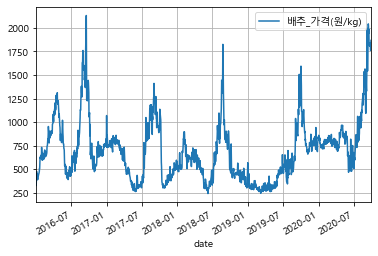

In [253]:
agri1 = data[['요일'] + [agri_price[0]]]


In [284]:
s = agri1[agri1['요일']=='일요일']
s[s[agri_price[0]]>0]

,요일,배추_가격(원/kg)
date,,
2016-01-31,일요일,1048.0
2016-09-11,일요일,1590.0
2017-01-22,일요일,842.0
2017-09-24,일요일,1378.0
2017-10-01,일요일,981.0
2018-02-04,일요일,2750.0
2018-02-11,일요일,1245.0
2018-09-16,일요일,925.0
2019-01-27,일요일,293.0


In [270]:
a = agri1[agri1['요일']=='일요일'][agri_price[0]]!=0
a.index

DatetimeIndex(['2016-01-03', '2016-01-10', '2016-01-17', '2016-01-24',
               '2016-01-31', '2016-02-14', '2016-02-21', '2016-02-28',
               '2016-03-06', '2016-03-13',
               ...
               '2020-07-26', '2020-08-02', '2020-08-09', '2020-08-16',
               '2020-08-23', '2020-08-30', '2020-09-06', '2020-09-13',
               '2020-09-20', '2020-09-27'],
              dtype='datetime64[ns]', name='date', length=237, freq=None)

In [204]:
agri1 = data[['요일'] + [agri_price[0]]]
error = agri1[agri1[agri_price[0]]==0]['요일']
error[error!='일요일']

date
2017-01-30    월요일
2017-10-06    금요일
2018-09-26    수요일
2020-01-27    월요일
Name: 요일, dtype: object

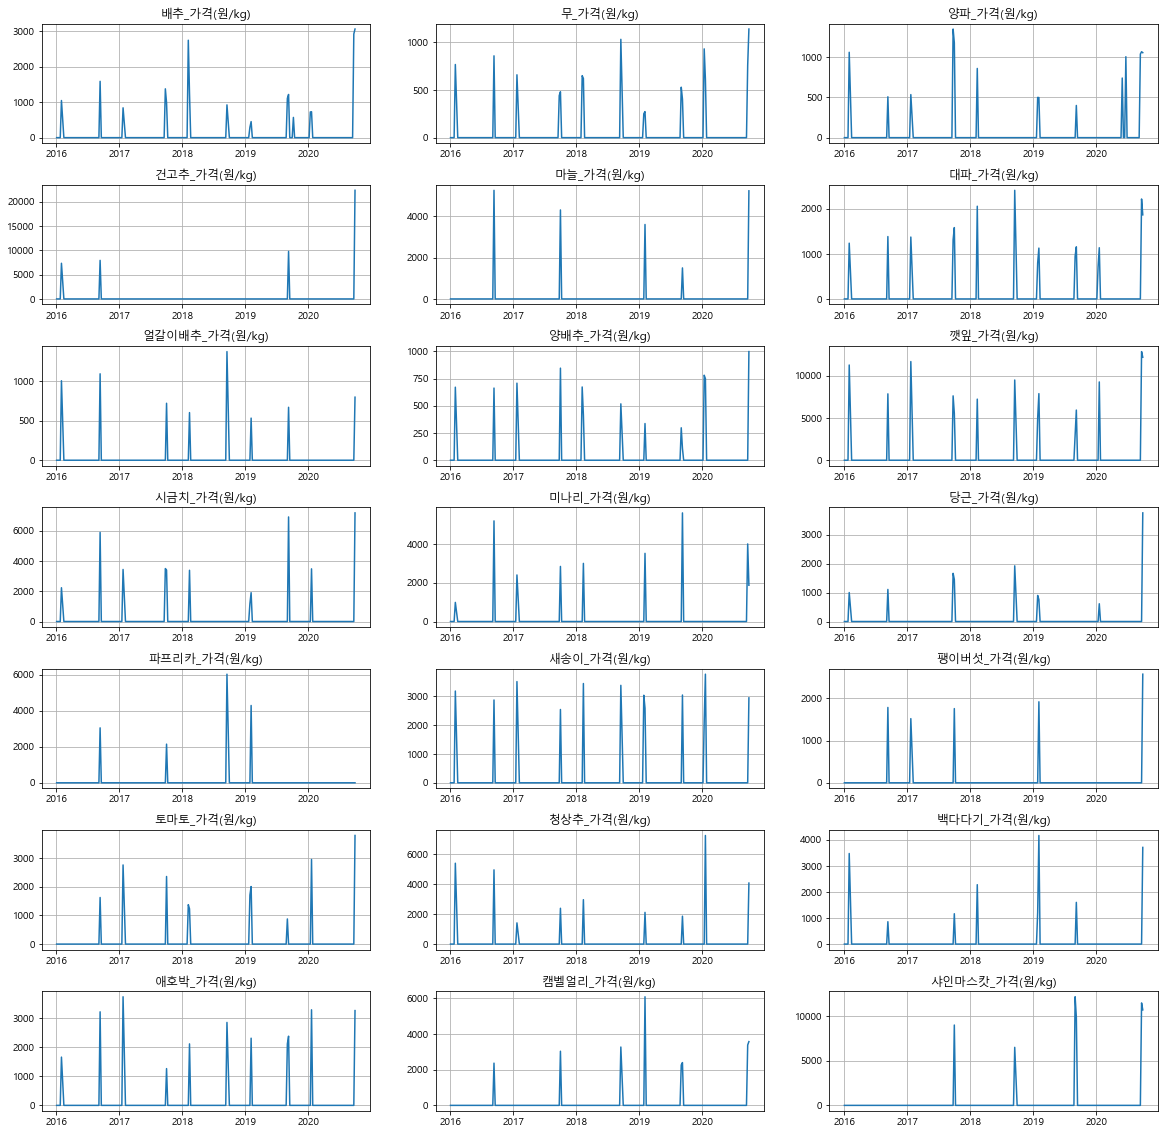

In [154]:

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = True
plt.rc('font', family='Malgun Gothic')

# for i in agri_price:
#     s = [i]
#     s.plot()
    
fig = plt.figure(figsize=(20,20))  # , constrained_layout=True
for i, price in enumerate(agri_price):
    ax = fig.add_subplot(7,3,i+1)
    plt.subplots_adjust(hspace=0.35)
    plt.title(price)
    plt.plot(data[data['요일']=='일요일'][price])
plt.show()

C:\Users\urse\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



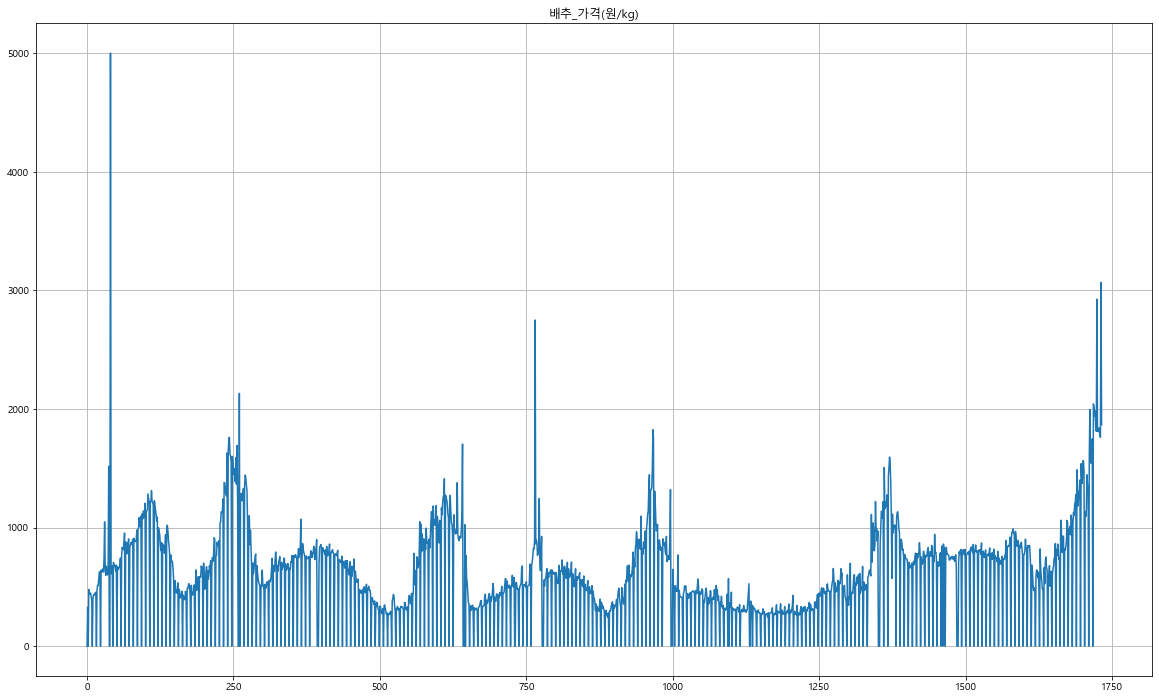

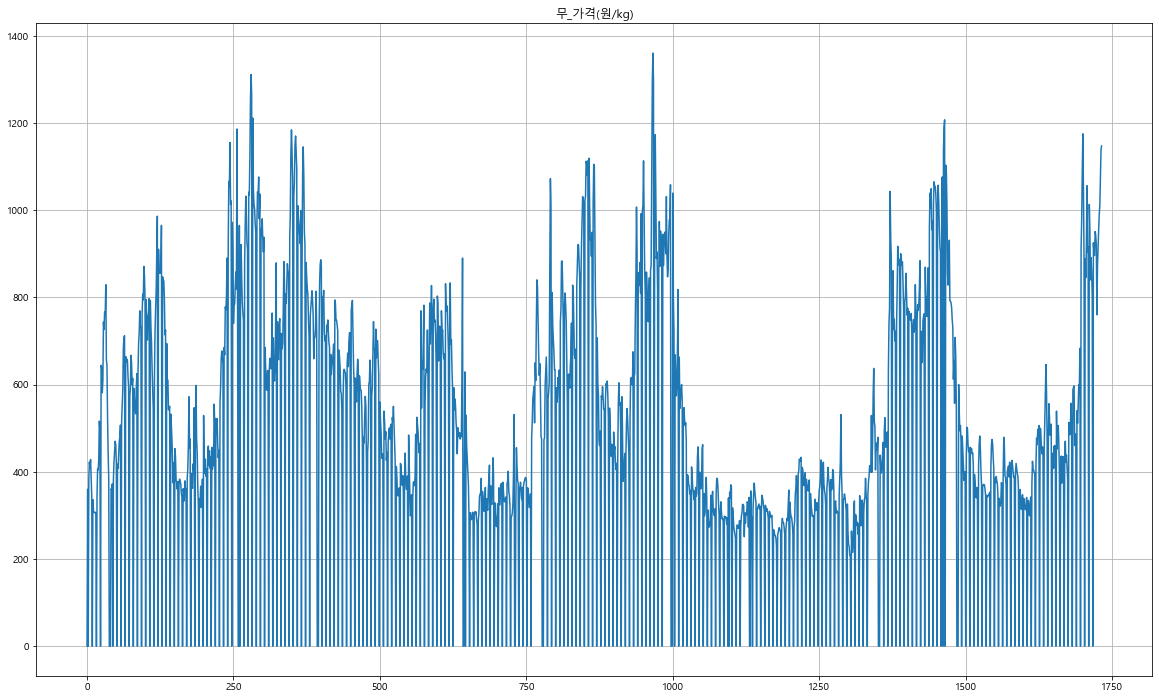

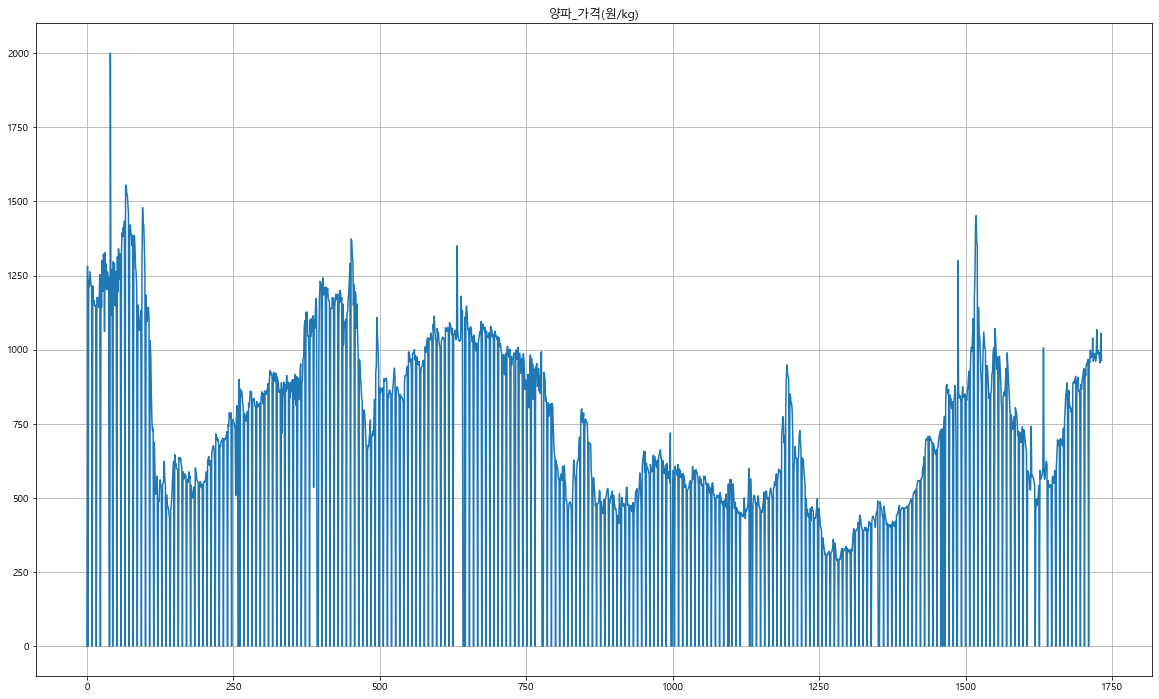

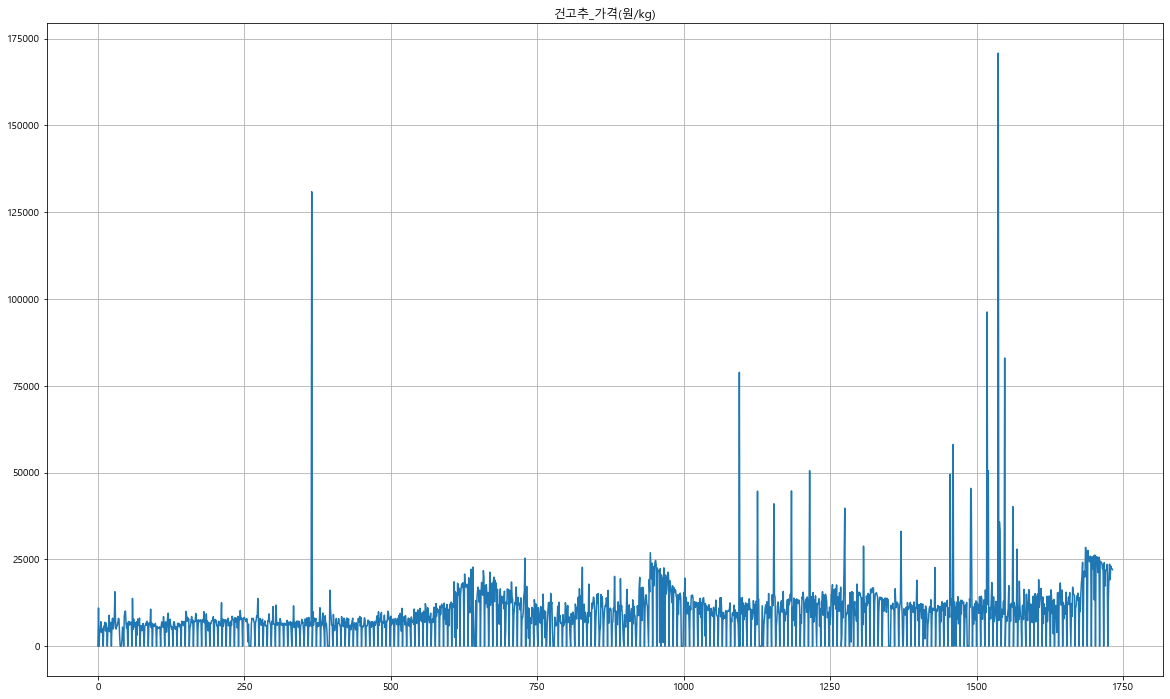

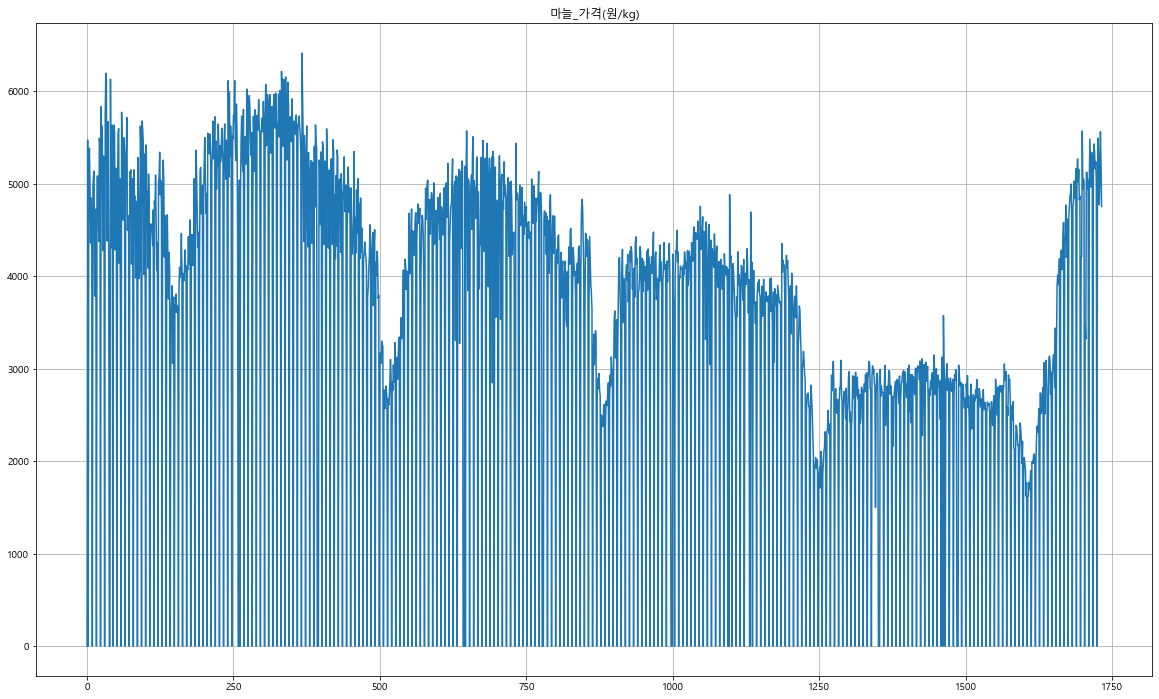

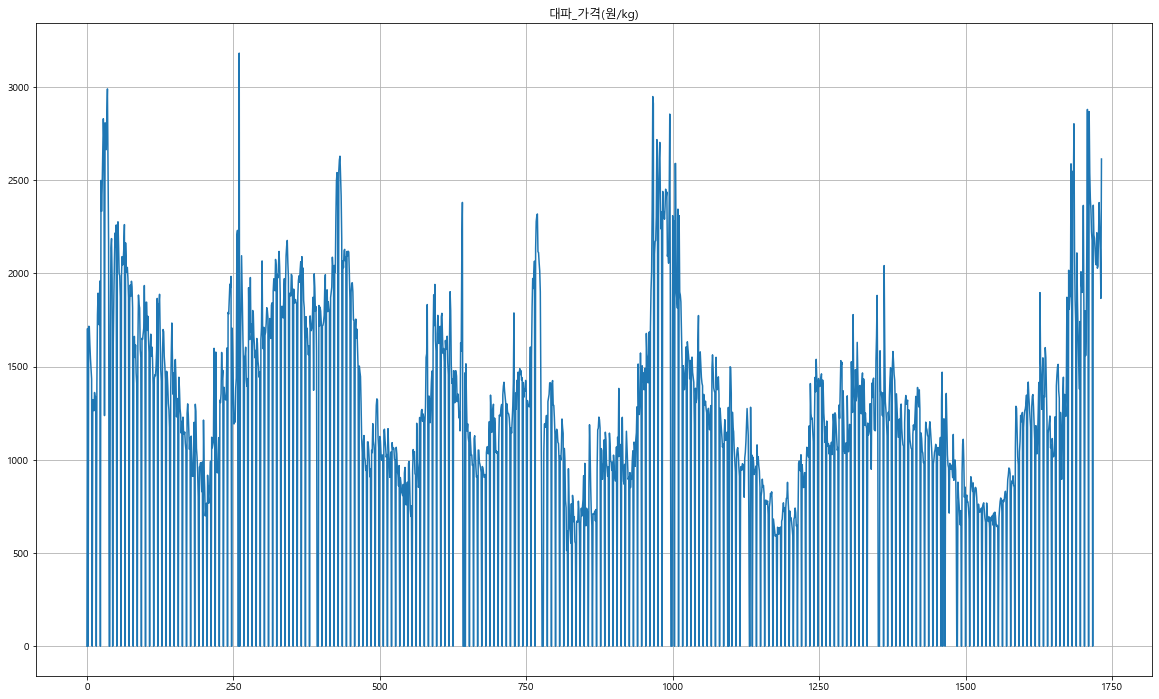

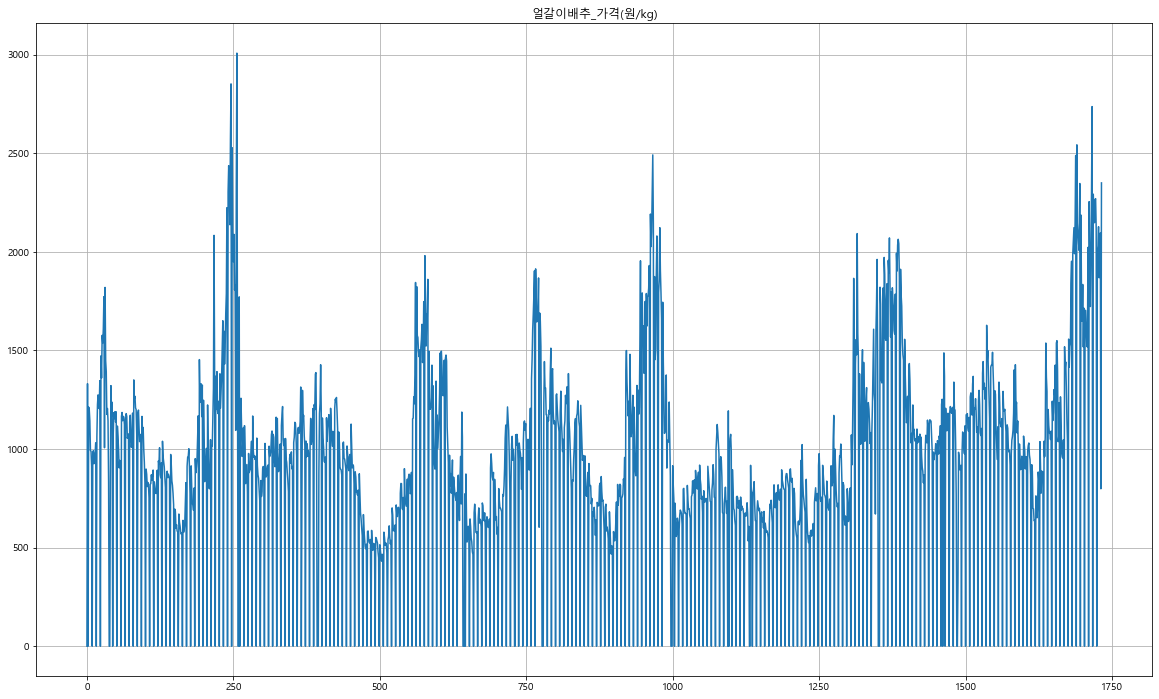

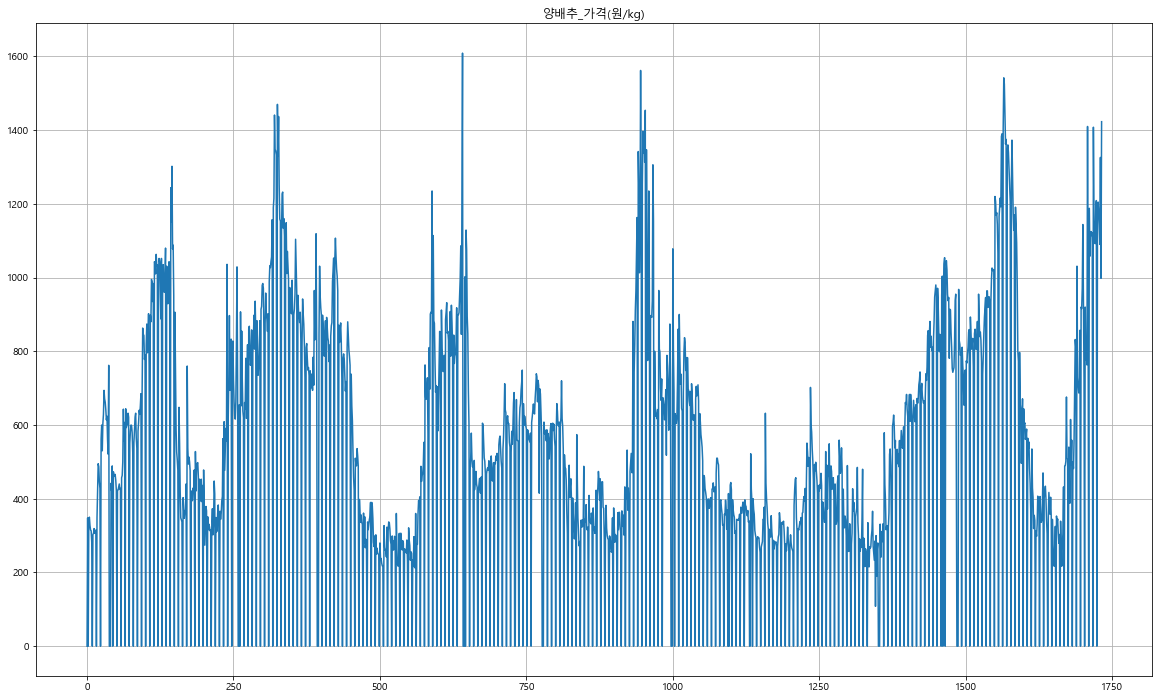

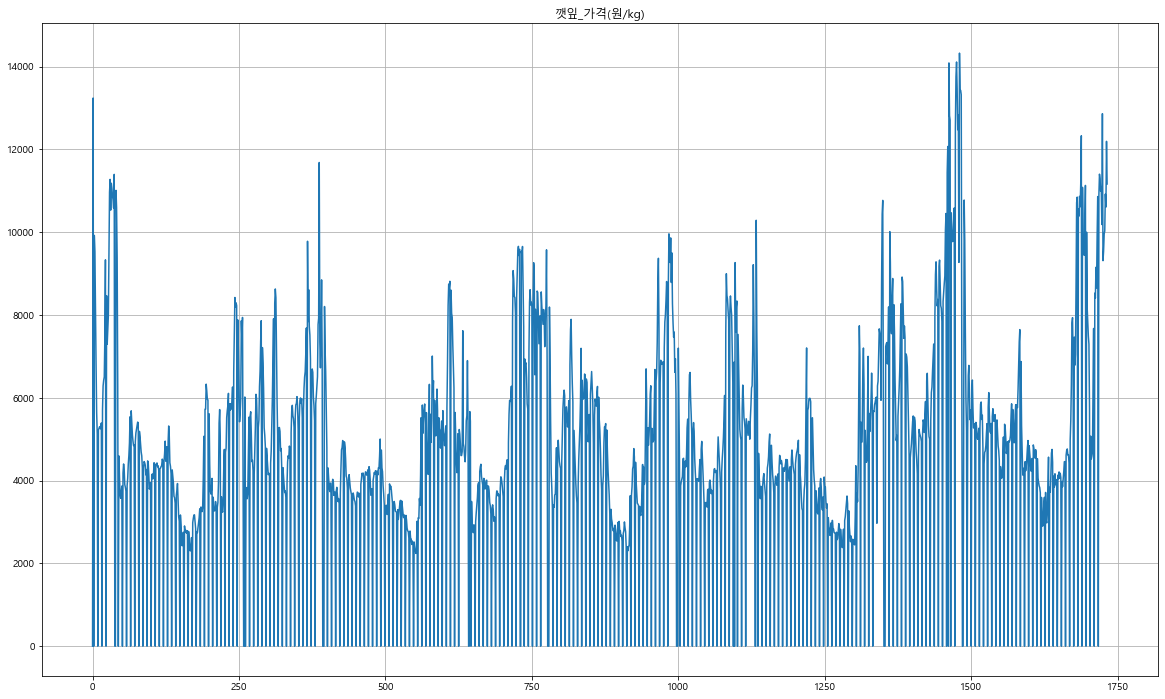

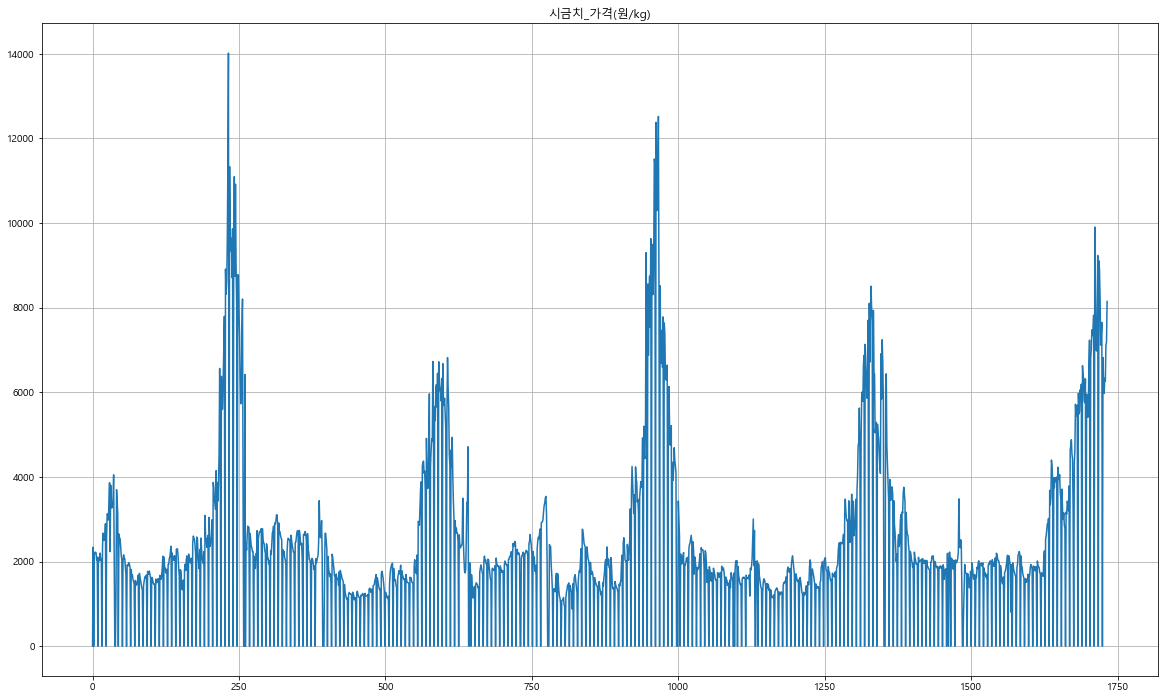

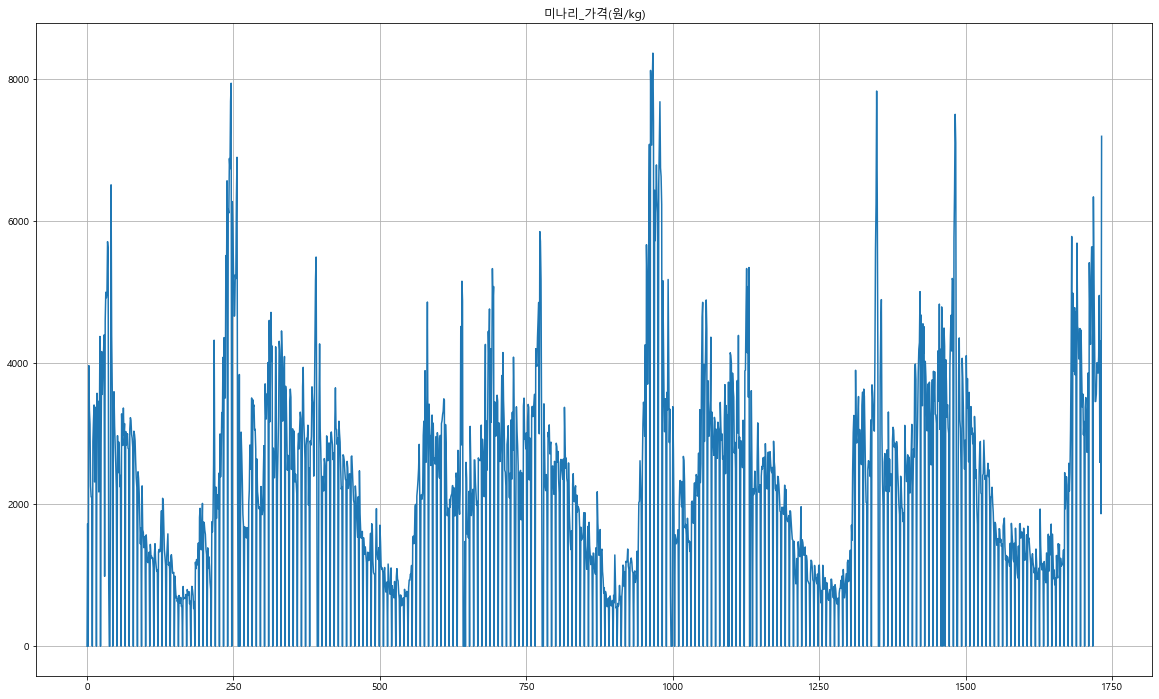

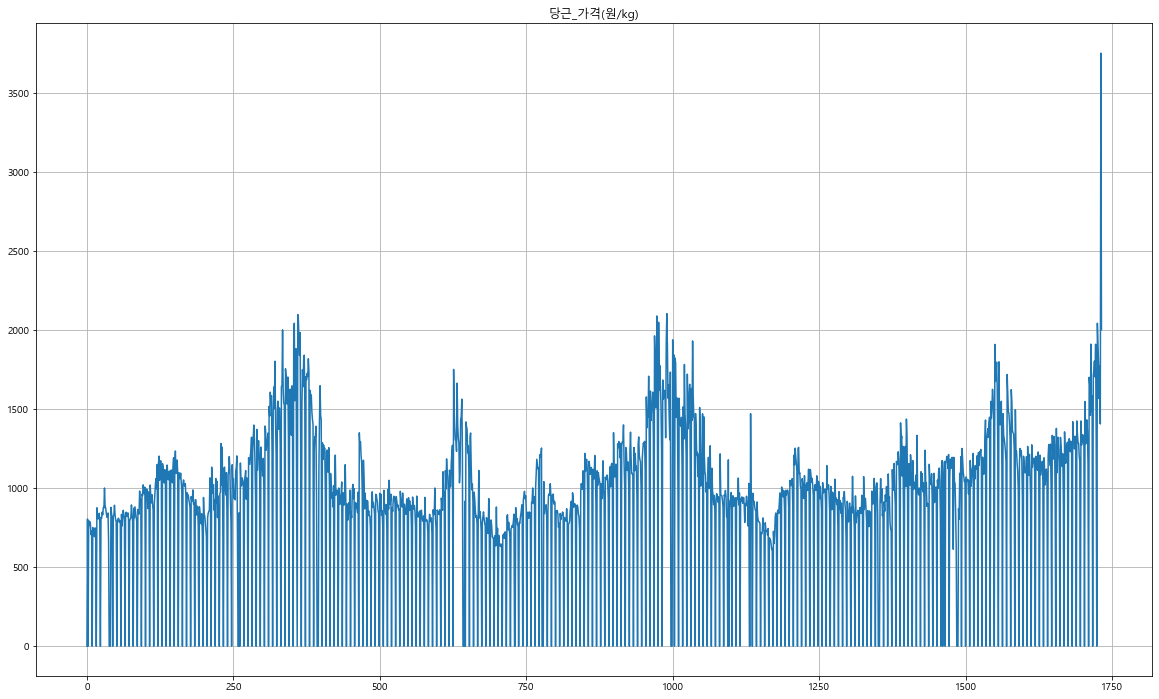

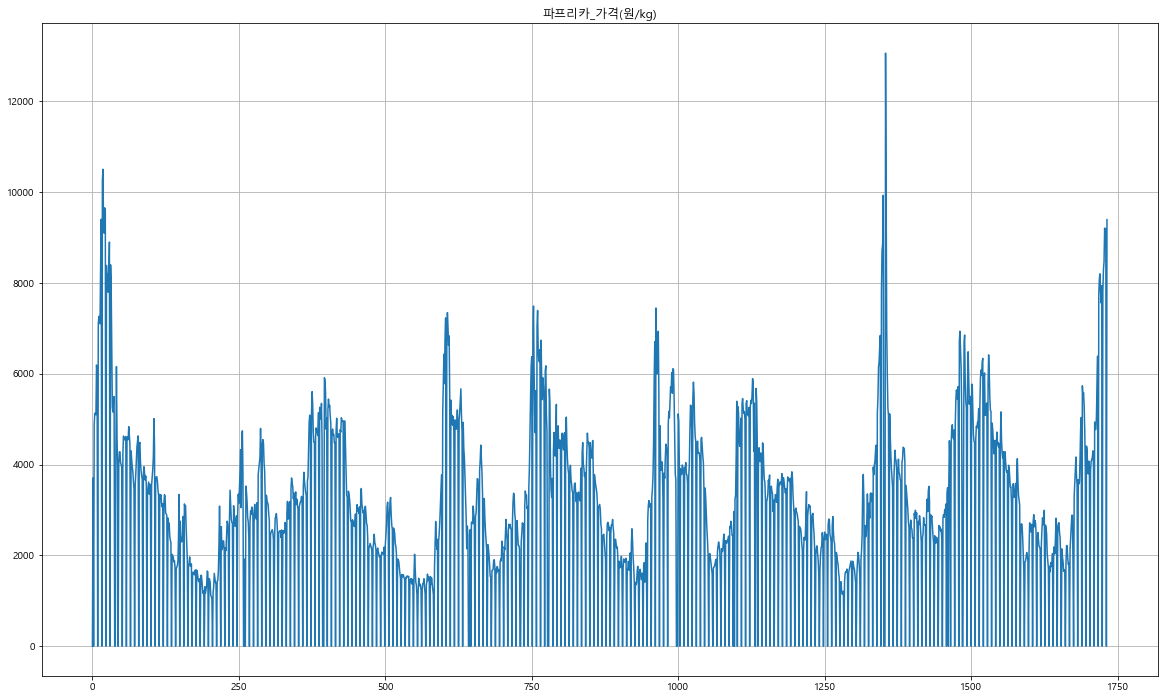

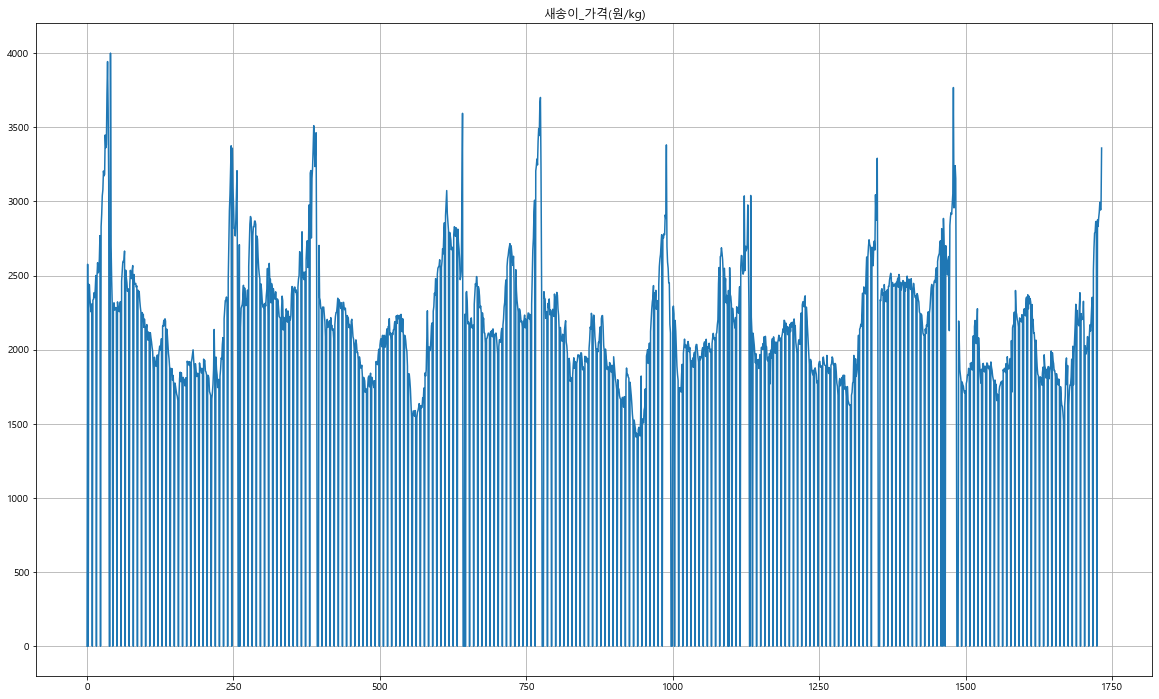

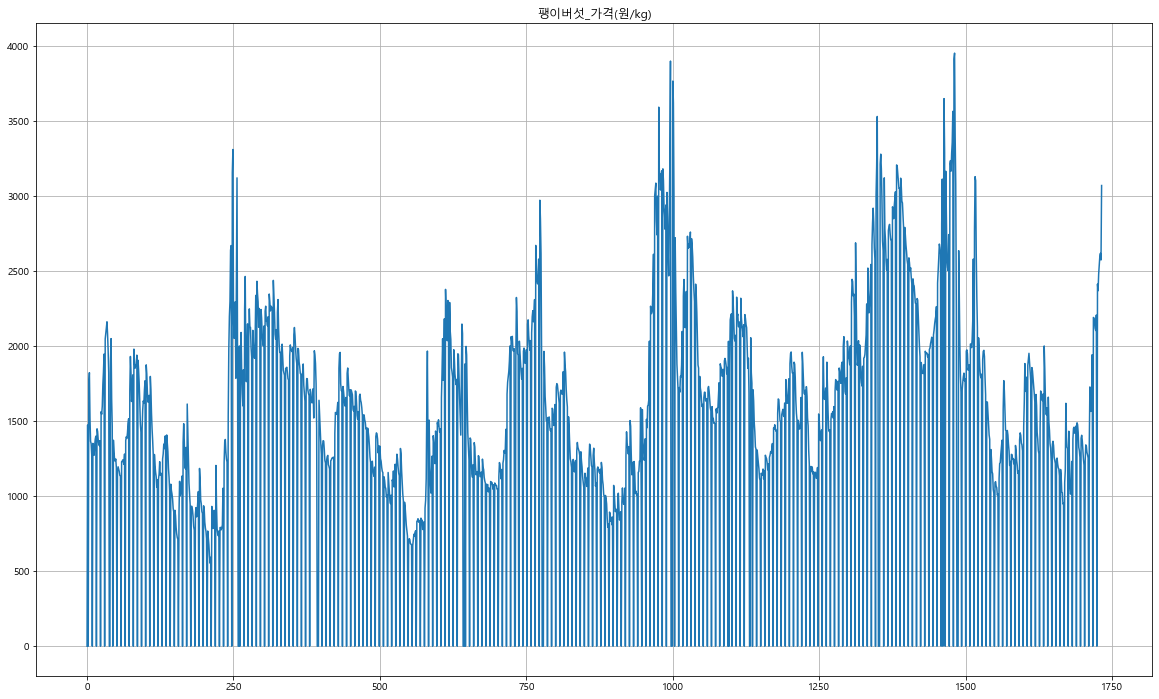

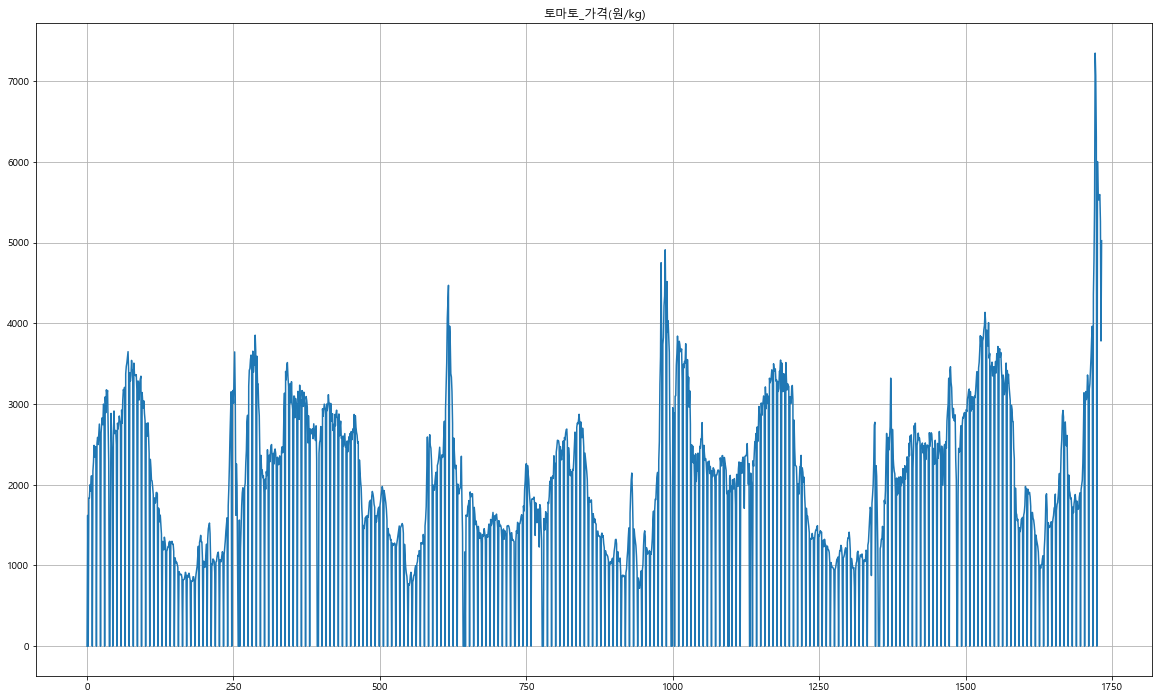

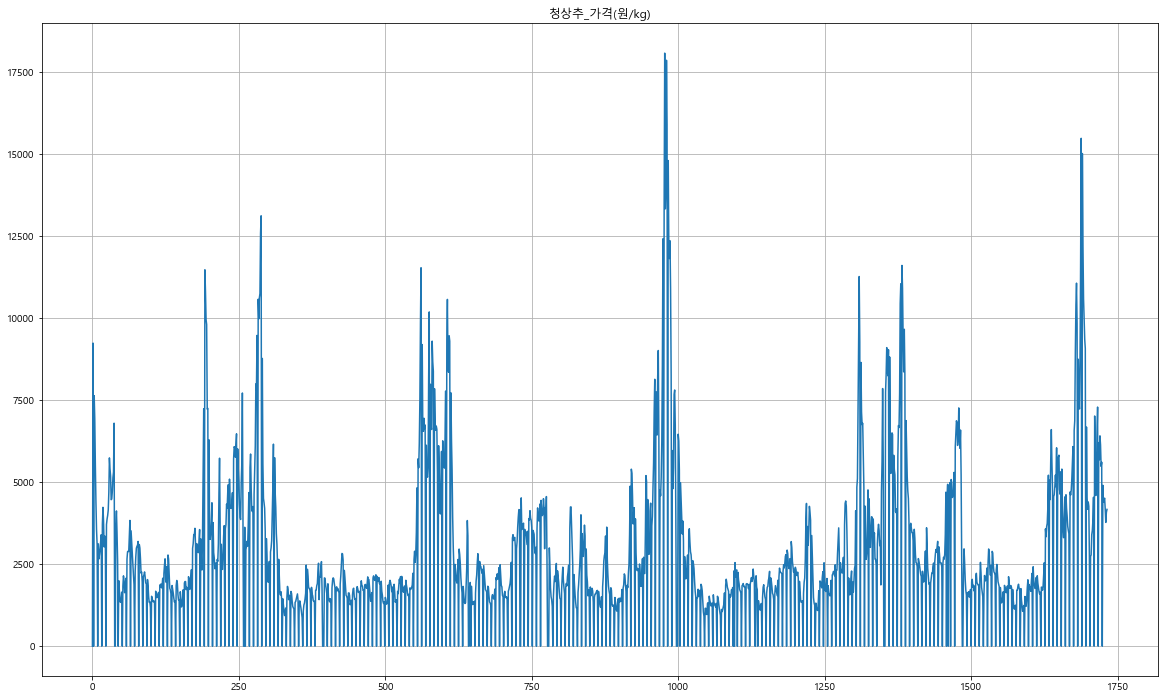

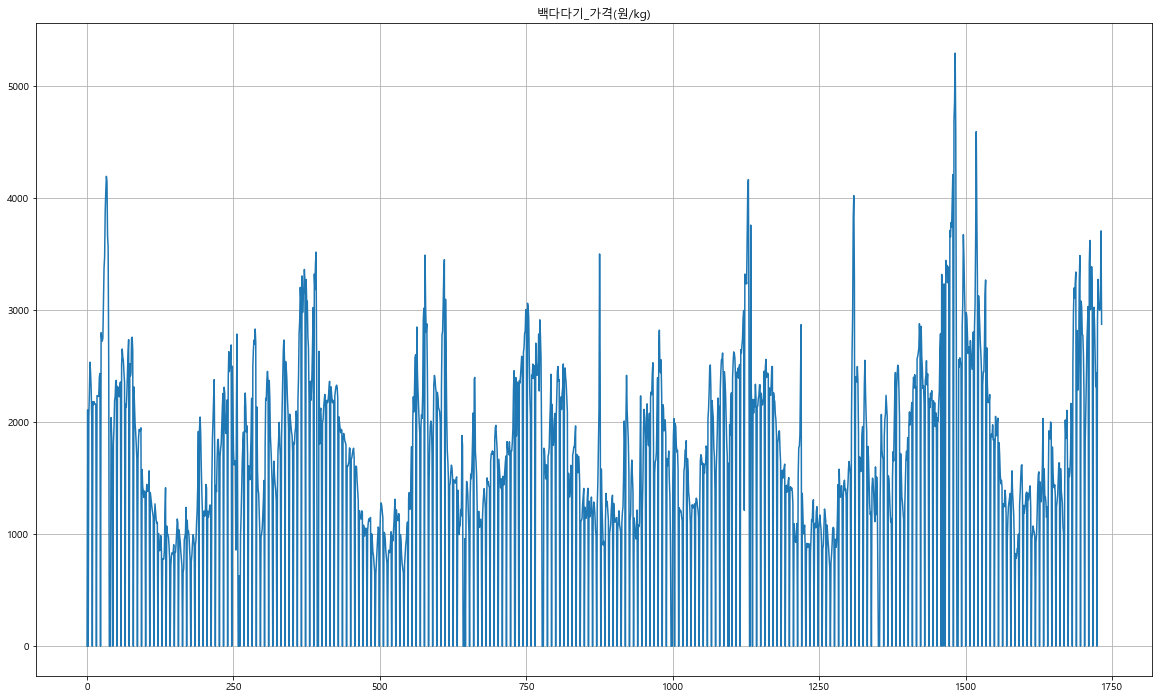

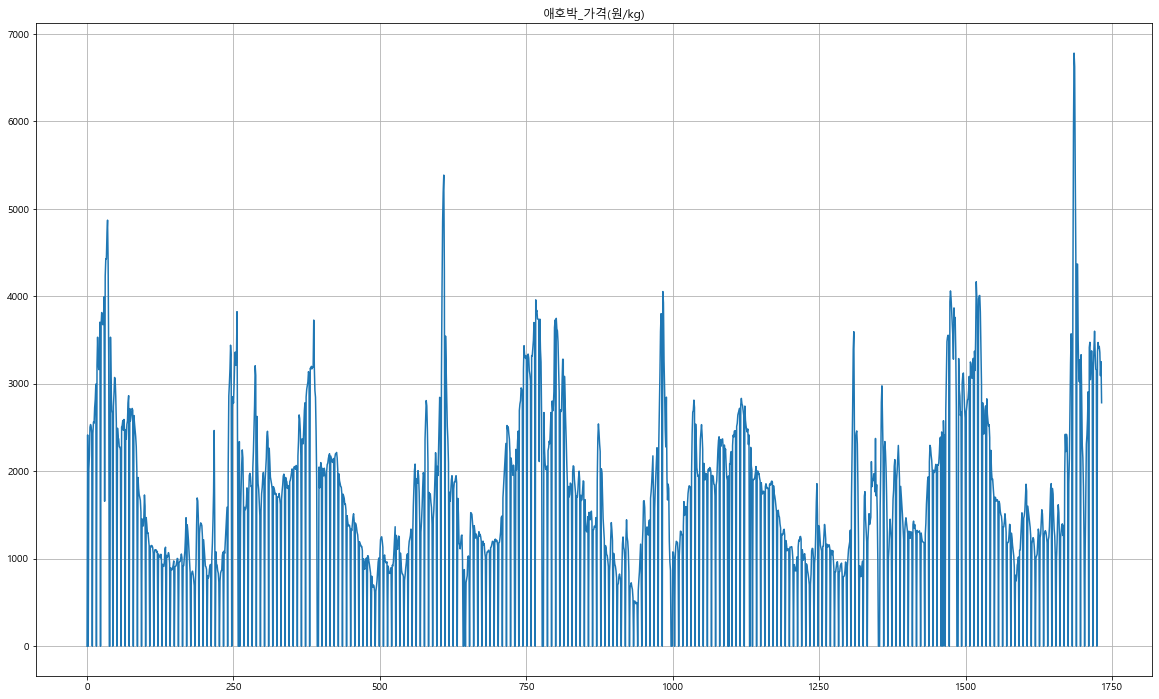

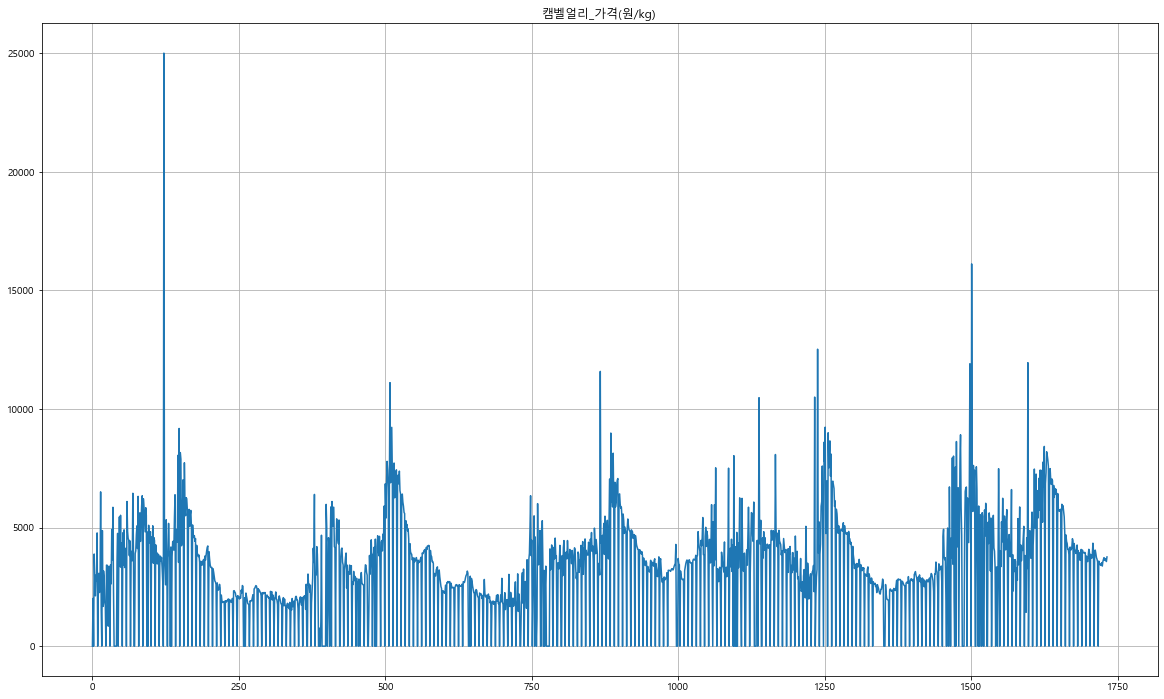

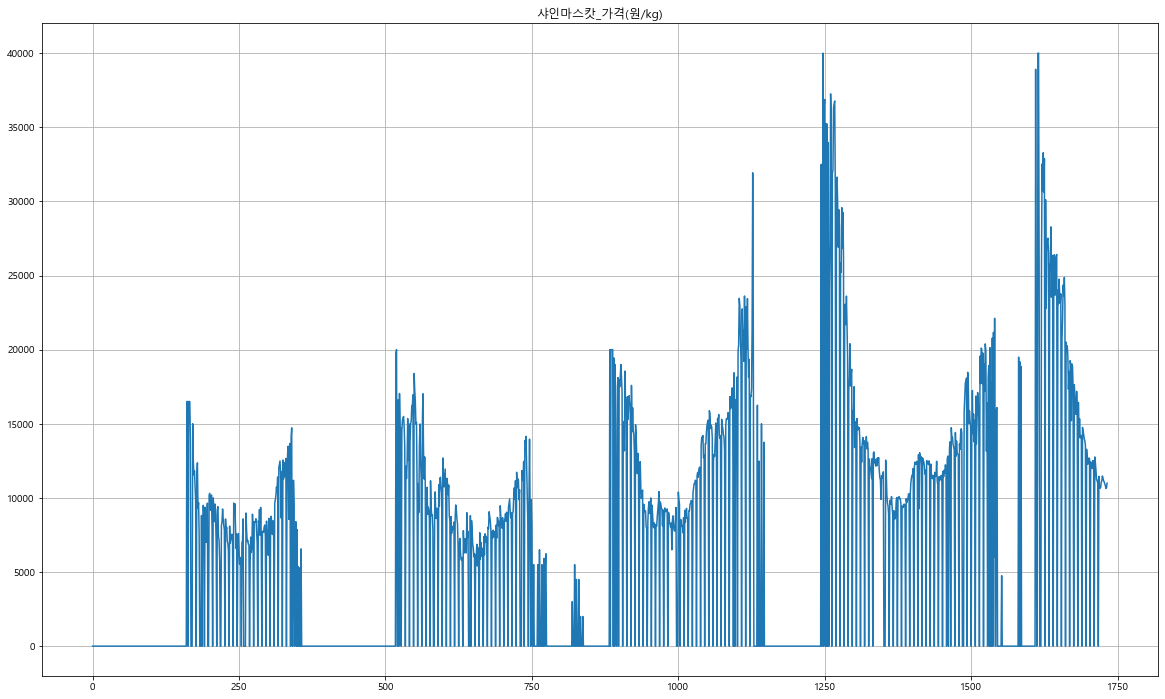

In [49]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = True
plt.rc('font', family='Malgun Gothic')

# fig = ) # 가로 세로 기준 inch 기준
for i, price in enumerate(agri_price):
    # ax = fig.add_subplot(7,3,i+1)
    plt.figure(figsize=(20,12))
    plt.title(price)
    plt.plot(data[price])
#     plt.savefig(str(i) + '_.png')
#     plt.show()

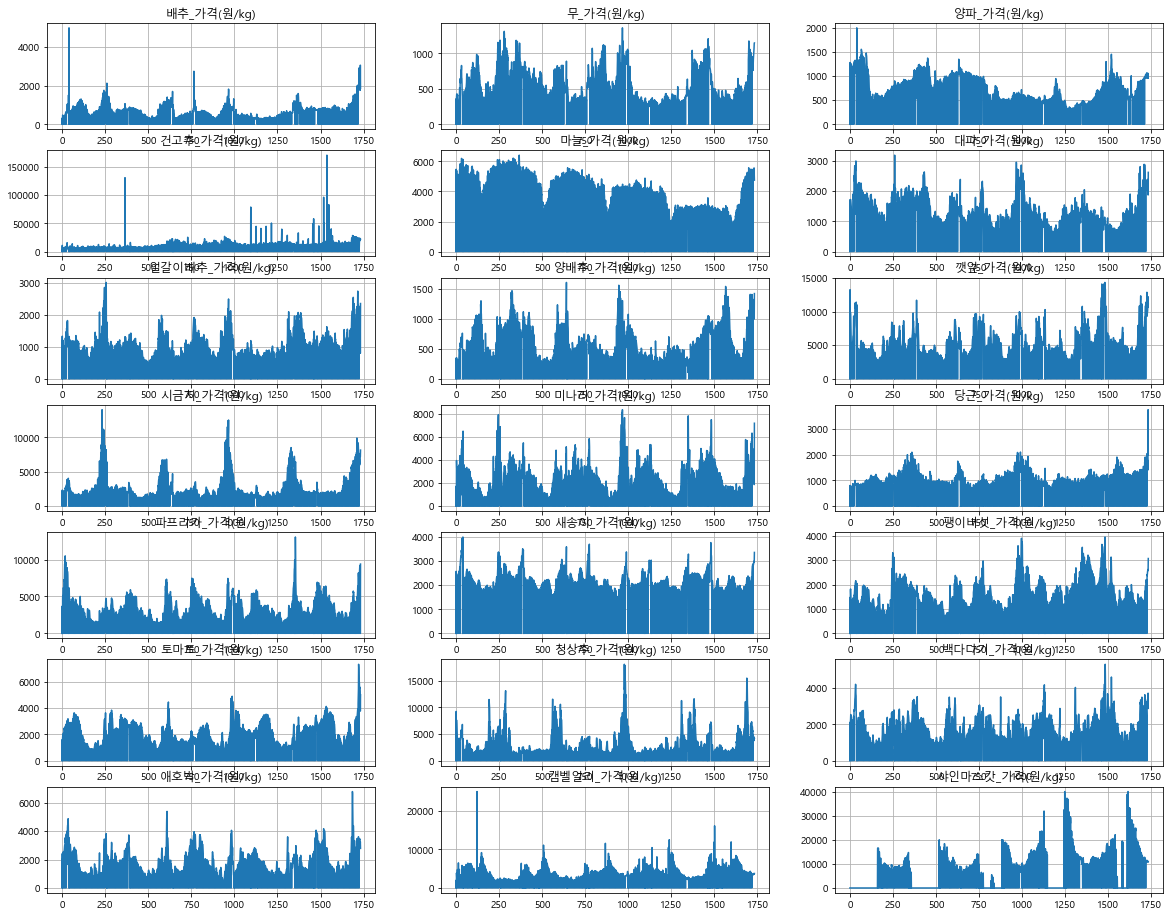

In [33]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = True
plt.rc('font', family='Malgun Gothic')

fig = plt.figure(figsize=(20,16)) 
for i, price in enumerate(agri_price):
    ax = fig.add_subplot(7,3,i+1)
    plt.title(price)
    plt.plot(data[price])
plt.show()

In [ ]:
### 최종 모델링을 하고서 공휴일들은 싹다 0으로